In [ ]:
# Notebook initialization for consistent paths (repo-aware)
import os, sys, pathlib

# Resolve repo root by walking up until we find 'src'
CWD = pathlib.Path.cwd()
ROOT = CWD
for _ in range(6):
    if (ROOT / 'src').exists():
        break
    ROOT = ROOT.parent
# Fallback to current if not found
if not (ROOT / 'src').exists():
    ROOT = CWD

PROJECT_ROOT = ROOT.resolve()
PROJECT_SRC = PROJECT_ROOT / 'src'
DATA_DIR = PROJECT_SRC / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_SRC) not in sys.path:
    sys.path.insert(0, str(PROJECT_SRC))

print(f'PROJECT_ROOT={PROJECT_ROOT}')
print(f'PROJECT_SRC={PROJECT_SRC}')
print(f'RAW_DATA_DIR={RAW_DATA_DIR}')
print(f'PROCESSED_DATA_DIR={PROCESSED_DATA_DIR}')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import gc
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [ ]:
# Load
CSV_PATH = f"{PROCESSED_DATA_DIR}/final_features_for_embeddings.csv"
df = pd.read_csv(CSV_PATH)
print(df.head())
df.info()

/var/folders/n7/_vnphx3n0hjd52f_bckm4r1w0000gp/T/ipykernel_15926/2324796203.py:3: DtypeWarning: Columns (7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


In [ ]:
# Target and features
y = df['loan_outcome'].astype(np.int8)
X = df.drop(columns=['loan_outcome']).copy()

del df
gc.collect()

# Basic cleaning helpers
num_like_as_object = ['avg_cur_bal', 'dti', 'mort_acc', 'num_op_rev_tl', 'revol_util']

# Strip non-numeric, coerce to float
for col in num_like_as_object:
    if col in X.columns:
        X[col] = (
            X[col]
            .astype(str)
            .str.replace(r"[^0-9.\-]", "", regex=True)
            .replace({"": np.nan, "-": np.nan})
            .astype(float)
        )

# Zip_code: ensure string (treat as categorical bucket)
if 'zip_code' in X.columns:
    X['zip_code'] = X['zip_code'].astype(str)

# earliest_cr_line: keep as string category (month-year); optionally parse to year index
# Example conversion to year (optional):
# def parse_year(s):
#     m = re.search(r"(19|20)\d{2}", str(s).lower())
#     return int(m.group(0)) if m else np.nan
# X['earliest_year'] = X['earliest_cr_line'].apply(parse_year)
# (If using earliest_year, consider dropping earliest_cr_line from categorical)

# Identify dtypes after cleaning
text_cols = ['title', 'emp_title']
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols = [col for col in cat_cols if col not in text_cols]

# Basic text sanitization for TF-IDF columns
for tcol in text_cols:
    if tcol in X.columns:
        X[tcol] = X[tcol].fillna("").astype(str)


In [ ]:
# MLP Architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 1) # Output layer for binary classification
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, stratify=y_temp, random_state=42
)

num_pos = int((y_train == 1).sum())
num_neg = int((y_train == 0).sum())
pos_weight = torch.tensor([float(num_neg) / max(1, float(num_pos))], device=device, dtype=torch.float32)
print(f"Pos Weight: {pos_weight}")

del X_temp, y_temp
gc.collect()

Pos Weight: tensor([3.7092])


0

In [7]:
preprocessor_mlp = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=True))
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        #=== TF-IDF STEPS ===
        ("loan_title_tfidf", 
         TfidfVectorizer(min_df=10, max_features=250, stop_words='english', ngram_range=(1, 2)), 
         'title'),
        
        ("emp_title_tfidf", 
         TfidfVectorizer(min_df=5, max_features=500, stop_words='english', ngram_range=(1, 2)), 
         'emp_title'),
    ],
    remainder='drop', # Drop any columns not specified
    sparse_threshold=0.0
)

# Fit on train only and transform all sets
X_train_enc = preprocessor_mlp.fit_transform(X_train).astype(np.float32)
X_val_enc   = preprocessor_mlp.transform(X_val).astype(np.float32)
X_test_enc  = preprocessor_mlp.transform(X_test).astype(np.float32)

del X_train, X_val, X_test
gc.collect()

# The output is now a dense NumPy array, perfect for PyTorch
print("Encoded shapes:", X_train_enc.shape)
print("Dtype:", X_train_enc.dtype)
D = X_train_enc.shape[1]

Encoded shapes: (876521, 2514)
Dtype: float32


In [8]:
# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train_enc)
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(1)

del X_train_enc, y_train
gc.collect()

X_val_tensor = torch.from_numpy(X_val_enc)
y_val_tensor = torch.from_numpy(y_val.values.astype(np.float32)).unsqueeze(1)

del X_val_enc, y_val
gc.collect()

X_test_tensor = torch.from_numpy(X_test_enc)
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32)).unsqueeze(1)

del X_test_enc
gc.collect()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

print("DataLoaders for MLP are ready.")

DataLoaders for MLP are ready.


In [10]:
model = MLP(input_size=D).to(device)

loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
epochs = 100

# Early Stopping Parameters
patience = 6
patience_counter = 0
best_loss = np.inf

for epoch in range(epochs):
    # Track weight norm on CPU to avoid device quirks
    w0_before = model.layers[0].weight.detach().to("cpu").norm().item()

    # Training Phase
    model.train()
    train_loss_sum = 0.0
    train_examples = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Safety: replace any NaNs/Infs that might slip through
        images = torch.nan_to_num(images, nan=0.0, posinf=1e6, neginf=-1e6)
        labels = torch.nan_to_num(labels, nan=0.0)
        
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("Warning: NaN/Inf in outputs; clipping inputs")
            outputs = torch.clamp(outputs, -20.0, 20.0)
        loss = loss_function(outputs, labels)
        if torch.isnan(loss) or torch.isinf(loss):
            print("Warning: NaN/Inf loss; skipping step")
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        batch_size = labels.size(0)
        train_loss_sum += loss.item() * batch_size
        train_examples += batch_size

    avg_train_loss = train_loss_sum / max(1, train_examples)

    # Validation Phase
    model.eval()
    val_loss_sum = 0.0
    val_examples = 0
    with torch.no_grad():
        mean_prob = 0.0
        batches = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            images = torch.nan_to_num(images, nan=0.0, posinf=1e6, neginf=-1e6)
            labels = torch.nan_to_num(labels, nan=0.0)
            outputs = model(images)
            outputs = torch.clamp(outputs, -20.0, 20.0)
            loss = loss_function(outputs, labels)
            probs = torch.sigmoid(outputs).mean().item()
            mean_prob += probs
            batches += 1
            batch_size = labels.size(0)
            val_loss_sum += loss.item() * batch_size
            val_examples += batch_size

    avg_val_loss = val_loss_sum / max(1, val_examples)
    mean_prob = mean_prob / max(1, batches)
    w0_after = model.layers[0].weight.detach().to("cpu").norm().item()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | mean(p)= {mean_prob:.4f} | w0 Δ: {w0_after - w0_before:+.6f}")

    if avg_val_loss < best_loss:
        torch.save(model.state_dict(), 'Final_MLP_model.pth')
        best_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("--- Training Finished ---")

Epoch 1/100 | Train Loss: 0.9797 | Val Loss: 0.9736 | mean(p)= 0.4635 | w0 Δ: +13.461871
Epoch 2/100 | Train Loss: 0.9674 | Val Loss: 0.9740 | mean(p)= 0.4502 | w0 Δ: +14.041943
Epoch 3/100 | Train Loss: 0.9588 | Val Loss: 0.9729 | mean(p)= 0.4592 | w0 Δ: +15.418396
Epoch 4/100 | Train Loss: 0.9470 | Val Loss: 0.9773 | mean(p)= 0.4505 | w0 Δ: +14.803444
Epoch 5/100 | Train Loss: 0.9303 | Val Loss: 0.9854 | mean(p)= 0.4539 | w0 Δ: +13.879578
Epoch 6/100 | Train Loss: 0.9072 | Val Loss: 0.9951 | mean(p)= 0.4451 | w0 Δ: +13.030273
Epoch 7/100 | Train Loss: 0.8794 | Val Loss: 1.0174 | mean(p)= 0.4362 | w0 Δ: +12.278008
Epoch 8/100 | Train Loss: 0.8489 | Val Loss: 1.0364 | mean(p)= 0.4300 | w0 Δ: +11.577263
Epoch 9/100 | Train Loss: 0.8200 | Val Loss: 1.0637 | mean(p)= 0.4247 | w0 Δ: +10.912811
Early stopping triggered at epoch 9
--- Training Finished ---


In [ ]:
del train_dataset, val_dataset, train_loader, val_loader
gc.collect()

0

Evaluating Model Performance on Test Set...

**=== Calculating Optimal Threshold ===**
Best Threshold found: 0.5184

--- Final Classification Report (Optimal Threshold) ---
              precision    recall  f1-score   support

           0       0.88      0.66      0.75    215748
           1       0.34      0.66      0.45     58165

    accuracy                           0.66    273913
   macro avg       0.61      0.66      0.60    273913
weighted avg       0.76      0.66      0.69    273913

ROC AUC Score: 0.7153

--- Final Confusion Matrix ---


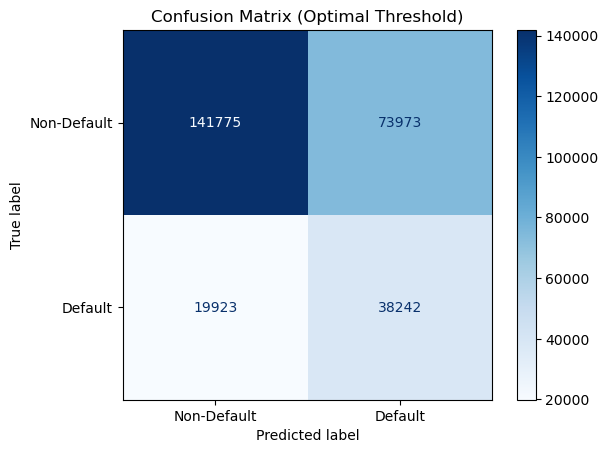

Accuracy : 0.6572050249531786
Recall    : 0.6574744262013238
Precision : 0.3407922292028695
F1-score  : 0.44890245333959383
ROC-AUC   : 0.7153050804895462

--- Model Evaluation Complete ---

--- Final Classification Report (Stale Threshold) ---
              precision    recall  f1-score   support

           0       0.88      0.62      0.73    215748
           1       0.33      0.69      0.45     58165

    accuracy                           0.64    273913
   macro avg       0.61      0.66      0.59    273913
weighted avg       0.77      0.64      0.67    273913

ROC AUC Score: 0.7153

--- Final Confusion Matrix ---


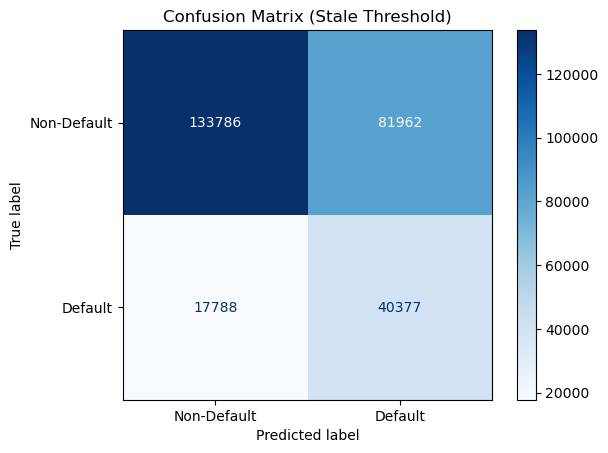

Accuracy : 0.6358332755290913
Recall    : 0.6941803490071349
Precision : 0.33004193266251974
F1-score  : 0.44738066746443295
ROC-AUC   : 0.7153050804895462

--- Model Evaluation Complete ---


In [11]:
# --- 1. Load Best Model and Get Predictions ---
print("Evaluating Model Performance on Test Set...")

# Load the weights from your best epoch
# This assumes your model variable is already defined (e.g., model = MLP(...))
model.load_state_dict(torch.load('Final_MLP_model.pth'))
model.to(device) # Ensure model is on the correct device
model.eval()

# Collect the model's predicted probabilities for the test set
y_prob_list = []
with torch.no_grad():
    for data, _ in test_loader:
        # Use the general `device` variable for robustness
        data = data.to(device)
        
        logits = model(data)
        probs = torch.sigmoid(logits)
        y_prob_list.append(probs.cpu().numpy())

# Concatenate the probabilities from all batches into a single array
y_prob = np.concatenate(y_prob_list).ravel()


# --- 2. Find Optimal Threshold and Make Final Predictions ---
print("\n**=== Calculating Optimal Threshold ===**")

# Use y_test (from your train_test_split) as the ground truth
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate F1 score for each threshold to find the best balance
# Add a small epsilon (1e-9) to avoid division by zero
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Get the best threshold
best_threshold_idx = np.argmax(f1_scores[:-1]) # Exclude the last value
best_threshold = thresholds[best_threshold_idx]
print(f"Best Threshold found: {best_threshold:.4f}")

# Apply the best threshold to get your final predictions
y_pred = (y_prob >= best_threshold).astype(int)


# --- 3. Display Final Results ---
print("\n--- Final Classification Report (Optimal Threshold) ---")

# Print the full report
print(classification_report(y_test, y_pred))

# Print the final ROC AUC score (uses probabilities)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Display the final confusion matrix
print("\n--- Final Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["Non-Default", "Default"]).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix (Optimal Threshold)")
plt.show()
# Metrics
print("Accuracy :", accuracy_score (y_test, y_pred))
print("Recall    :", recall_score    (y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("F1-score  :", f1_score       (y_test, y_pred))
print("ROC-AUC   :", roc_auc_score  (y_test, y_prob))
print("\n--- Model Evaluation Complete ---")



y_pred = (y_prob >= 0.5).astype(int)


# --- 3. Display Final Results ---
print("\n--- Final Classification Report (Stale Threshold) ---")

# Print the full report
print(classification_report(y_test, y_pred))

# Print the final ROC AUC score (uses probabilities)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Display the final confusion matrix
print("\n--- Final Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["Non-Default", "Default"]).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix (Stale Threshold)")
plt.show()
# Metrics
print("Accuracy :", accuracy_score (y_test, y_pred))
print("Recall    :", recall_score    (y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred))
print("F1-score  :", f1_score       (y_test, y_pred))
print("ROC-AUC   :", roc_auc_score  (y_test, y_prob))
print("\n--- Model Evaluation Complete ---")